In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.transform import resize
import numpy as np
from PIL import Image
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo


__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']


model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes, final_act=True):
        super(Fire, self).__init__()
        self.final_act = final_act
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        if self.final_act:
            self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.final_act:
            maybe_last_act = self.expand3x3_activation
        else:
            maybe_last_act = lambda x: x
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            maybe_last_act(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version=1.0, final_act=True, num_classes=1000):
        super(SqueezeNet, self).__init__()
        if version not in [1.0, 1.1]:
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1.0 or 1.1 expected".format(version=version))
        self.num_classes = num_classes
        if version == 1.0:
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256, final_act=final_act),
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256, final_act=final_act),
                Fire(512, 64, 256, 256, final_act=final_act),
            )
        # Final convolution is initialized differently form the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AvgPool2d(13, stride=1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)


def squeezenet1_0(pretrained=False, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SqueezeNet(version=1.0, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['squeezenet1_0']))
    return model


def squeezenet1_1(pretrained=False, final_act=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SqueezeNet(version=1.1, final_act=final_act, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['squeezenet1_1']))
    return model


class ExtractorNet(nn.Module):
    def __init__(self, model_path, device):
        super(ExtractorNet, self).__init__()
        self.model_path = model_path
        self.model = squeezenet1_1(pretrained=False, final_act=False)
        self.feature_extractor = nn.Sequential(*list(self.model.children())[0][:-1])
        if device.type == 'cpu':
            self.feature_extractor.load_state_dict(torch.load(self.model_path, map_location='cpu'))
        else:
            self.feature_extractor.load_state_dict(torch.load(self.model_path))
        self.mean = torch.FloatTensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        self.std = torch.FloatTensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

    def forward(self, x):
        x = (x - self.mean) / self.std
        emb = self.feature_extractor(x)
        emb = emb.mean(-1).mean(-1)
        emb = F.normalize(emb, 1)
        return emb

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_path = '/home/liam/adehack/model_base.pth'
feature_extractor = ExtractorNet(model_path, device).to(device)

im = np.asarray(Image.open('/home/liam/adehack/pillims/cropped_sponge0.png'))
with torch.no_grad():
    imtch = torch.FloatTensor(im[:75, :75, :3]).permute(2, 0, 1).unsqueeze(0).to(device)
    fts_sponge = feature_extractor(imtch)

In [2]:
import os
from tqdm import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import matplotlib.pyplot as plt
import time
import torch.nn.functional as F


def interp_ws(ws1, ws2, alpha):
    alpha = torch.cuda.FloatTensor([alpha])
    out = []
    for w1, w2 in zip(ws1, ws2):
        out.append((1 - alpha) * w1 + alpha * w2)
    return out

def get_W(in_units, out_units, kernel_size=0):
    if kernel_size:
        W = (torch.cuda.FloatTensor(out_units, in_units, kernel_size, kernel_size).uniform_() - 0.5) * 0.1
    W = (torch.cuda.FloatTensor(out_units, in_units).uniform_() - 0.5) * 2
    W.requires_grad = True
    return W
    #return (torch.cuda.FloatTensor(out_units, in_units).normal_()) * 1

def get_ws(widths, kernel_size=0):
    ws = []
    for w0, w1 in zip(widths[:-1], widths[1:]):
        ws.append(get_W(w0, w1, kernel_size=kernel_size))
    return ws

def meshgrid_conv(size_y, size_x):
    out = np.stack(np.meshgrid(np.linspace(-1, 1, size_y),
                               np.linspace(-1, 1, size_x)), 0).sum(0)
    return torch.FloatTensor(out).cuda()

def meshgrid(size_y, size_x, o_x=0., o_y=0., kernel_size=0):
    if kernel_size:
        return meshgrid_conv(size_y, size_x)
    r = 3.0**0.9
    a = torch.linspace(o_x-r, o_x+r, size_x)
    b = torch.linspace(o_y-r, o_y+r, size_y)
    x_t = a.repeat(size_y)
    y_t = b.repeat(size_x, 1).t().contiguous().view(-1)
    return (torch.stack([x_t, y_t], 1).cuda())

def forward_conv(xy, ws, size_y, size_x, kernel_size):
    k = kernel_size // 2
    K = kernel_size
    for w in ws:
        xy = F.pad(xy, [k, k, k, k])
        xy = xy.view(1, w.shape[1], size_y + k * 2, size_x + k * 2)
        xy = F.conv2d(xy, w)
#         xy = torch.tanh(xy)
        xy = torch.relu(xy)
    ret = xy
    ret = (ret - ret.min()) / (ret.max() - ret.min())
    return ret.view(size_y, size_x, 3).cpu().numpy()
    

def forward(xy, ws, size_y, size_x, kernel_size=0):
    if kernel_size:
        return forward_conv(xy, ws, size_y, size_x, kernel_size)
    ret = xy
    for w in ws:
        ret = torch.matmul(ret, w.t())
        ret = torch.tanh(ret)
    ret = (ret - ret.min()) / (ret.max() - ret.min())
    return ret.view(size_y, size_x, 3)


with torch.no_grad():
    size_y = 108 * 5
    size_x = 192 * 5
    kernel_size = 0
    widths = [1 if kernel_size else 2, 8, 8, 8, 8, 8, 3]
    widths = [widths[0]] + [i * 10 for i in widths[1:-1]] + [widths[-1]]

    #xy = meshgrid(size_y, size_x)
    ws1 = get_ws(widths, kernel_size=kernel_size)
    xy = meshgrid(size_y, size_x, kernel_size=kernel_size)
    # xy = torch.tanh(xy)
    out = forward(xy, ws1, size_y, size_x, kernel_size=kernel_size)
    plt.figure(figsize=[15]*2)
    plt.imshow(out.detach().cpu().numpy())
    plt.show()

<Figure size 1500x1500 with 1 Axes>

In [3]:
opt = torch.optim.SGD(ws1, lr=0.01, momentum=0.9)

In [4]:
target = torch.zeros([1, 512]).to(device)
target[0, 0:10] = 1.
target = F.normalize(target, 1)

In [8]:

size_y = 24
size_x = 24
xy = meshgrid(size_y, size_x, kernel_size=kernel_size)

for i in range(5000):
    opt.zero_grad()
    out = forward(xy, ws1, size_y, size_x, kernel_size=kernel_size)
    fts = feature_extractor(out.permute(2, 0, 1))
    loss = F.mse_loss(fts, fts_sponge) * 1e5
    loss.backward()
    opt.step()
    if i % 500 == 0:
        print(loss.item())


1.1169734001159668
1.1165353059768677
1.0765024423599243
1.066519856452942
1.0602049827575684
1.0677059888839722
1.0587832927703857
1.0533958673477173
1.0559473037719727
1.100192666053772


In [21]:
xybig = torch.cat([xythis] * 2, 0)

In [23]:
xybig.shape

torch.Size([1036800, 2])

In [24]:


def forward2(xy, ws, size_y, size_x, kernel_size=0):
    if kernel_size:
        return forward_conv(xy, ws, size_y, size_x, kernel_size)
    ret = xy
    for w in ws:
        ret = torch.matmul(ret, w.t())
        ret = torch.tanh(ret)
    ret = (ret - ret.min()) / (ret.max() - ret.min())
    return ret.view(2, size_y, size_x, 3)

In [25]:
%timeit with torch.no_grad():    forward2(xybig, ws1, size_y, size_x, kernel_size=kernel_size)

147 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


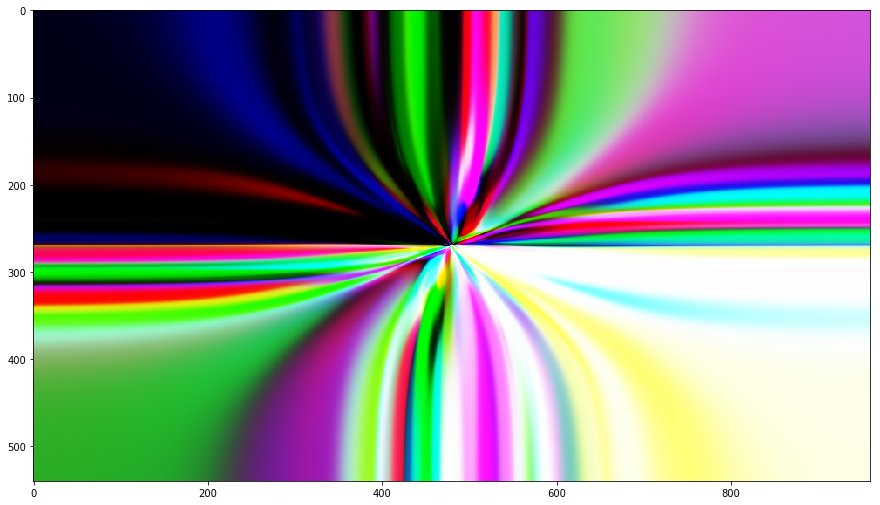

In [10]:
size_y = 108 * 5
size_x = 192 * 5
kernel_size = 0
widths = [1 if kernel_size else 2, 8, 8, 8, 8, 8, 3]

xythis = meshgrid(size_y, size_x, kernel_size=kernel_size)
xythis = torch.tanh(xythis)
out = forward(xythis, ws1, size_y, size_x, kernel_size=kernel_size)
plt.figure(figsize=[15]*2)
plt.imshow(out.detach().cpu().numpy())
plt.show()

In [5]:
widths = [spect.shape[0] + 1 if kernel_size else spect.shape[0] + 2] + [8, 8, 8, 3]
ws1 = get_ws(widths, kernel_size=kernel_size)
ws2 = get_ws(widths, kernel_size=kernel_size)
num_weights = sum([w0 * w1 for i, (w0, w1) in enumerate(zip(widths[:-1], widths[1:]))])

In [6]:
time_of_each_frame = librosa.core.frames_to_time(np.arange(spect.shape[1]+1), sr=sr, hop_length=512)
spect_t = torch.FloatTensor((spect - spect.mean()) / spect.std()).cuda()
# spect_t[-5:] = spect_t[-5:] * 20

def get_im(xy, st, en, spect_t, ws, size_y, size_x, kernel_size, scale=1.0):
    spect_rep = spect_t[:, st:en].t().mean(0, keepdim=True)
    if kernel_size:
        xy = xy.view(1, 1, *xy.shape)
        spect_rep = spect_rep.view(*spect_rep.shape, 1, 1).repeat([1, 1, *xy.shape[-2:]])
        return forward(torch.cat([xy, spect_rep], 1) * scale, ws, size_y, size_x, kernel_size)
    spect_rep = spect_rep.repeat([xy.shape[0], 1])
    return forward(torch.cat([xy, spect_rep], 1) * scale, ws, size_y, size_x, kernel_size)

frame_rate = 25
weight_fade_seconds = 20
num_frames = frame_rate * seconds
step_size = spect_t.shape[1] / float(num_frames)
window_ratio = 3.
window_size = int(step_size * window_ratio)


ims = []
scale = 10
alpha = 0.0
for i_frame in tqdm(range(num_frames - 1)):
    st = np.abs(i_frame / float(frame_rate) - time_of_each_frame).argmin()
    en = st + window_size
    
    alpha += 1.0 / (weight_fade_seconds * frame_rate)
    if alpha >= 1.0:
        alpha = 0.0
        ws1 = [i * 1. for i in ws2]
        ws2 = get_ws(widths, kernel_size=kernel_size)
    ws = interp_ws(ws1, ws2, alpha)
    
    im = get_im(xy, st, en, spect_t, ws, size_y, size_x, kernel_size, scale=scale)
    ims.append(im)
    st = int(round(st + step_size))

100%|██████████| 1124/1124 [00:22<00:00, 50.15it/s]


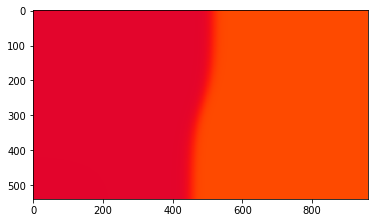

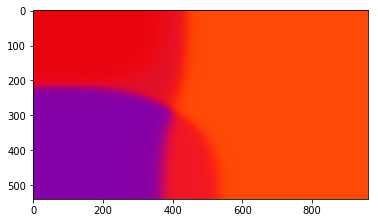

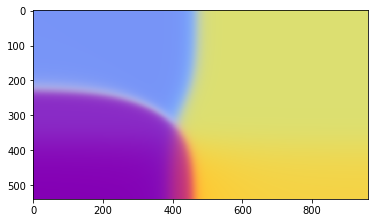

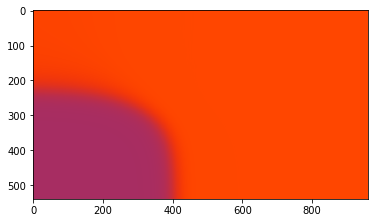

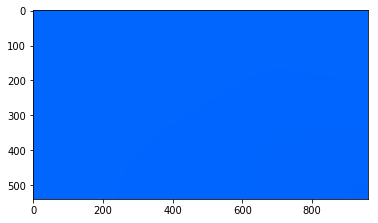

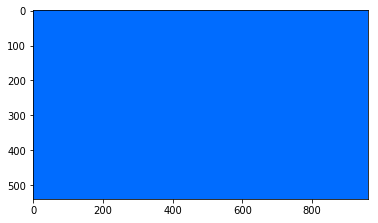

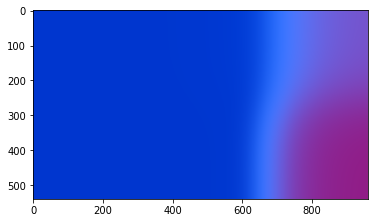

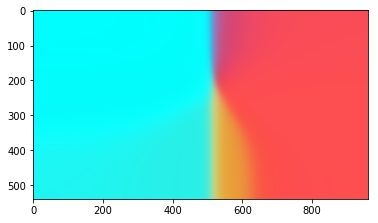

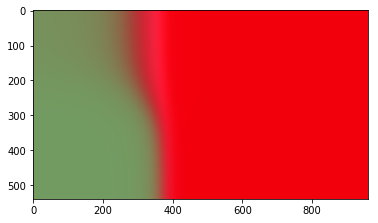

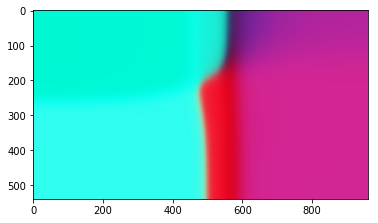

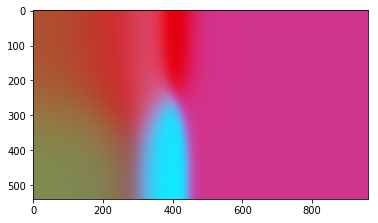

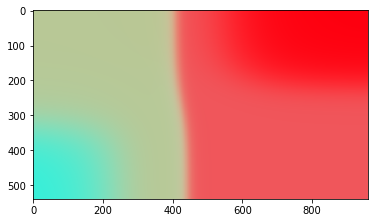

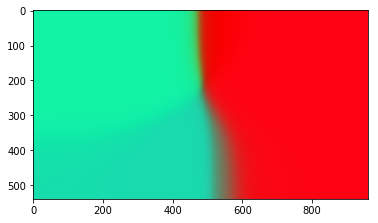

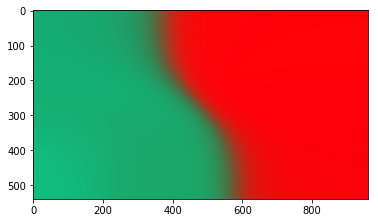

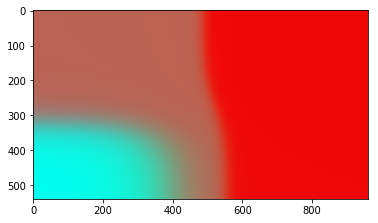

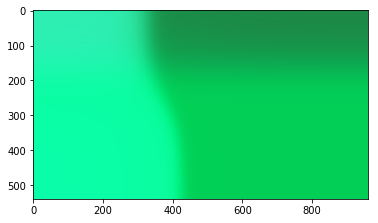

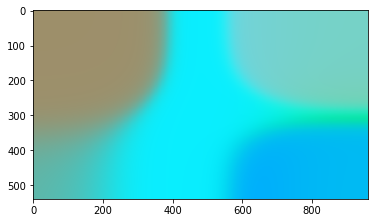

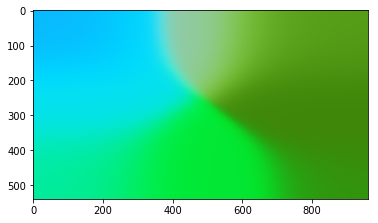

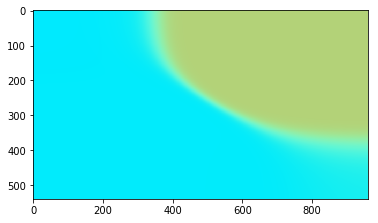

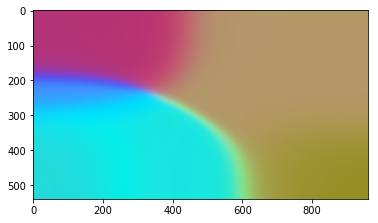

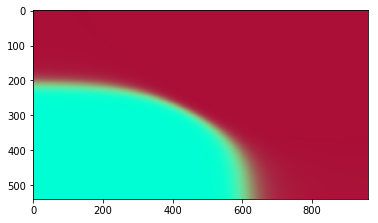

In [7]:
for im in ims[::len(ims)//20]:
    plt.imshow(im)
    plt.show()

In [8]:
from scipy.io.wavfile import write
write('tmp.wav', sr, np.clip((audio_subset * 32768.), -32768, 32768).astype(np.int16))

In [9]:
import os
import shutil
from skimage.color import hsv2rgb
hsv2rgb = lambda x: x
shutil.rmtree('cool2')
os.makedirs('cool2')
for i, im in tqdm(enumerate(ims)):
    plt.imsave('cool2/im%06d.png' % (i + 1), hsv2rgb(im))

1124it [01:47, 10.41it/s]


In [75]:
ws1 = get_ws(widths)
ws2 = get_ws(widths)

ims = []
num_frames = 200

now = time.time()
for alpha, o_x, o_y in zip(np.linspace(0, 1, num_frames),
                           np.linspace(-1, 1, num_frames),
                           np.linspace(-1, 1, num_frames)):
    ws_this = interp_ws(ws1, ws2, alpha)
    xy = meshgrid(size, o_x, o_y)
    out = forward(xy, ws_this)
    ims.append(out)
    
print (time.time() - now)

4.694384574890137
